This code is a result of a recent research on portfolio theory. One can see the paper

 ***Halidias, Nikolaos. "A novel portfolio optimization method and its application to the hedging problem" Monte Carlo Methods and Applications, vol. 30, no. 3, 2024, pp. 249-267,*** and the references therein. (https://www.degruyterbrill.com/document/doi/10.1515/mcma-2024-2009/html)

See also the book
***Halidias, Nikolaos and Stamatiou, Ioannis S.. Stochastic Analysis: Financial Mathematics with Matlab®, De Gruyter, 2026.*** (https://www.degruyterbrill.com/document/isbn/9783111443737/html?lang=en&srsltid=AfmBOorukbLCPRdRPn2Mu2kqSWiGttsEAPF6wBfVNixx4fAFzxycr6Fl)

At the webpage of the ***Actuarial-Financial Laboratory*** https://www.samos.aegean.gr/actuar/nick/actfinlabeng.htm one can find also other useful informations.



We use all the call and put options from the yahoo finace in order to construct the portfolio. If you choose experiment=1 then we use the lastPrices otherwise the bid-ask prices. If for any reason you want to take account only some of the call and put options you should manually set the data stock_value, call_strikes,put_strikes,call_ask,call_bid,put_ask,put_bid.


Before using this code you should have in your mind a prediction about the future price. This prediction can be some prices with some weights, like $KKmax=[280,0.8]$.
At first, you should specify the amount to be invested, the maximum possible loss for your portfolio, the firm, the expiration date of the options, the maximum number of options of each strike and the maximum number of options of all types.

In practice, before the expiration you should have:

1.   The amount 100*strike price for each call you have bought
2.   100 shares for each call that you have sell
3.   100 shares for each put that you have bought
4.   The amount 100*strike price for each put that you have sell

That means that the amount V, the maximum possible loss D, the number of shares and options and the bank account that you want to set  should be  100 times lower.


If you want to download data from Yahoo finance you should set Data_given=1. Otherwise you should have an excel file from which the data will be stored.

In [5]:
import numpy as np
import yfinance as yf
from scipy.optimize import LinearConstraint, Bounds, milp
from prettytable import PrettyTable
import matplotlib.pyplot as plt

# -----------------------------
# Επιλογή πηγής δεδομένων
# -----------------------------
while True:
    Data_given = input("\nΕπιλέξτε 1 για δεδομένα από Yahoo Finance και 0 από Excel: ").strip()
    try:
        Data_given = int(Data_given)
        if Data_given in (0, 1): break
        print("Παρακαλώ εισάγετε μόνο 0 ή 1.")
    except ValueError:
        print("Μη έγκυρη είσοδος. Εισάγετε μόνο 0 ή 1.")

while True:
    experiment = input("\nΕπιλέξτε 0 για να χρησιμοποιηθούν οι τιμές bid/ask και 1 για lastprices: ").strip()
    try:
        experiment = int(experiment)          # <-- διόρθωση: διαβάζουμε το experiment, όχι το Data_given
        if experiment in (0, 1): break
        print("Παρακαλώ εισάγετε μόνο 0 ή 1.")
    except ValueError:
        print("Μη έγκυρη είσοδος. Εισάγετε μόνο 0 ή 1.")

# -----------------------------
# Είσοδοι Yahoo/Excel
# -----------------------------
if Data_given == 1:
    Firm = input("Εισάγετε το ticker symbol (π.χ. AAPL): ").strip().upper()
    stock = yf.Ticker(Firm)
    expirations = stock.options
    if not expirations:
        raise RuntimeError(f"Δεν βρέθηκαν expiration dates για {Firm}")

    print("\nΔιαθέσιμες Expiration Dates:")
    for i, date in enumerate(expirations):
        print(f"{i+1}. {date}")

    while True:
        choice_str = input("\nΕπιλέξτε αριθμό expiration date: ").strip()
        try:
            choice = int(choice_str) - 1
            if 0 <= choice < len(expirations):
                ExpirationDate = expirations[choice]
                print(f"\nΦορτώνω δεδομένα για {Firm} με expiration date {ExpirationDate}...")
                break
            else:
                print("Μη έγκυρη επιλογή. Παρακαλώ εισάγετε έναν αριθμό από τη λίστα.")
        except ValueError:
            print("Μη έγκυρη εισαγωγή. Παρακαλώ εισάγετε έναν αριθμό.")
else:
    excel_file = input("Εισάγετε το Excel file (π.χ. options_data.xlsx): ").strip()

# -----------------------------
# Συναρτήσεις λήψης δεδομένων
# -----------------------------
def options_bid_ask(firm, expiration_date, experiment_mode):
    import yfinance as yt
    stock_local = yt.Ticker(firm)                   # <-- διόρθωση: τοπικό Ticker
    stock_value = stock_local.history(period='1d')['Close'].iloc[-1]
    options_chain = stock_local.option_chain(expiration_date)

    calls = options_chain.calls
    puts  = options_chain.puts
    call_strikes = calls['strike'].to_numpy(float)
    put_strikes  = puts['strike'].to_numpy(float)

    if experiment_mode == 1:
        last_c = calls['lastPrice'].to_numpy(float)
        last_p = puts['lastPrice'].to_numpy(float)
        call_ask = last_c.copy(); call_bid = last_c.copy()
        put_ask  = last_p.copy(); put_bid  = last_p.copy()
    else:
        call_ask = calls['ask'].to_numpy(float)
        call_bid = calls['bid'].to_numpy(float)
        put_ask  = puts['ask'].to_numpy(float)
        put_bid  = puts['bid'].to_numpy(float)

    return float(stock_value), call_strikes, put_strikes, call_ask, call_bid, put_ask, put_bid

def options_bid_ask_excel(experiment_mode):
    import pandas as pd
    try:
        df = pd.read_excel(excel_file)
        stock_value = float(df.iloc[0, 0])
        call_strikes = df.iloc[:, 1].dropna().to_numpy(float)
        put_strikes  = df.iloc[:, 5].dropna().to_numpy(float)
        if experiment_mode == 1:
            call_ask = call_bid = df.iloc[:, 2].dropna().to_numpy(float)
            put_ask  = put_bid  = df.iloc[:, 6].dropna().to_numpy(float)
        else:
            call_ask = df.iloc[:, 4].dropna().to_numpy(float)
            call_bid = df.iloc[:, 3].dropna().to_numpy(float)
            put_ask  = df.iloc[:, 8].dropna().to_numpy(float)
            put_bid  = df.iloc[:, 7].dropna().to_numpy(float)
        return stock_value, call_strikes, put_strikes, call_ask, call_bid, put_ask, put_bid
    except FileNotFoundError:
        print(f"Error: '{excel_file}' not found. Please make sure the file exists.")
        return None, None, None, None, None, None, None

def _valid_mask(ask_arr, bid_arr):
    """Κρατά quotes με Ask>0, Bid>0 και πεπερασμένα."""
    ask_ok = np.isfinite(ask_arr) & (ask_arr > 0)
    bid_ok = np.isfinite(bid_arr) & (bid_arr > 0)
    return ask_ok & bid_ok

def _print_meta_table(ticker, expiration, stock_value, source, mode, perturb_pct):
    t = PrettyTable(['Ticker', 'Expiration', 'Stock Close', 'Data Source', 'Quote Mode', 'Διαταραχή %'])
    t.add_row([ticker, expiration, f'{stock_value:.4f}', source, mode, f'{perturb_pct:.2f}'])
    print("\n📋 Metadata")
    print(t)

def _print_options_table(call_strikes, call_bid, call_ask, put_strikes, put_bid, put_ask):
    t = PrettyTable(['Type', 'Strike', 'Bid', 'Ask'])
    # ταξινόμηση ανά strike
    for K, B, A in sorted(zip(call_strikes, call_bid, call_ask), key=lambda r: r[0]):
        t.add_row(['Call', f'{K:.2f}', f'{B:.2f}', f'{A:.2f}'])
    for K, B, A in sorted(zip(put_strikes, put_bid, put_ask), key=lambda r: r[0]):
        t.add_row(['Put',  f'{K:.2f}', f'{B:.2f}', f'{A:.2f}'])
    print("\n📊 Options (τελικά δεδομένα)")
    print(t)

# -----------------------------
# Λήψη δεδομένων
# -----------------------------
if Data_given == 1:
    stock_value, call_strikes, put_strikes, call_ask1, call_bid, put_ask1, put_bid = options_bid_ask(
        Firm, ExpirationDate, experiment
    )
    data_source = 'Yahoo'
    exp_label = ExpirationDate
else:
    stock_value, call_strikes, put_strikes, call_ask1, call_bid, put_ask1, put_bid = options_bid_ask_excel(experiment)
    data_source = 'Excel'
    exp_label = '(excel)'

if stock_value is None:
    raise RuntimeError("Αποτυχία εισαγωγής δεδομένων.")

# -----------------------------
# Φιλτράρισμα μη έγκυρων quotes
# -----------------------------
keep_call = _valid_mask(call_ask1, call_bid)
keep_put  = _valid_mask(put_ask1,  put_bid)

call_ask     = call_ask1[keep_call]
call_bid     = call_bid[keep_call]
call_strikes = call_strikes[keep_call]

put_ask      = put_ask1[keep_put]
put_bid      = put_bid[keep_put]
put_strikes  = put_strikes[keep_put]

if call_strikes.size == 0 and put_strikes.size == 0:
    raise RuntimeError("Δεν έμειναν έγκυρα strikes μετά το φιλτράρισμα.")

# -----------------------------
# Ερώτηση & εφαρμογή διαταραχής
# -----------------------------
perturb_pct = 0.0
while True:
    choice = input(
        "\nΘέλετε να χρησιμοποιήσετε τα δεδομένα όπως είναι ή να γίνει μικρή διαταραχή;\n"
        "1. Χωρίς διαταραχή\n"
        "2. Με διαταραχή (ask + x%, bid - x%)\n"
        "Επιλογή (1 ή 2): "
    ).strip()
    if choice in ('1', '2'):
        break
    print("Παρακαλώ εισάγετε 1 ή 2.")

if choice == '2':
    while True:
        try:
            percent = float(input("Εισάγετε το ποσοστό (%) διαταραχής (π.χ. 5 για ±5%): ").strip())
            if percent >= 0:
                perturb_pct = percent
                break
            else:
                print("Παρακαλώ εισάγετε μη αρνητικό αριθμό.")
        except ValueError:
            print("Μη έγκυρη εισαγωγή. Παρακαλώ εισάγετε έναν αριθμό.")

    factor_up = 1.0 + perturb_pct / 100.0
    factor_dn = 1.0 - perturb_pct / 100.0

    call_ask = np.round(call_ask * factor_up, 2)
    call_bid = np.round(call_bid * factor_dn, 2)
    put_ask  = np.round(put_ask  * factor_up, 2)
    put_bid  = np.round(put_bid  * factor_dn, 2)
else:
    # χωρίς διαταραχή: στρογγυλοποιούμε για όμορφη εκτύπωση (προαιρετικό)
    call_ask = np.round(call_ask, 2); call_bid = np.round(call_bid, 2)
    put_ask  = np.round(put_ask, 2);  put_bid  = np.round(put_bid, 2)

# -----------------------------
# Όμορφη εκτύπωση ΤΕΛΙΚΩΝ δεδομένων
# -----------------------------
quote_mode = 'LastPrice' if experiment==1 else 'Bid/Ask'
ticker_label = Firm if Data_given==1 else '(from Excel)'

_print_meta_table(
    ticker=ticker_label,
    expiration=exp_label,
    stock_value=stock_value,
    source=data_source,
    mode=quote_mode,
    perturb_pct=perturb_pct
)
_print_options_table(
    call_strikes=call_strikes, call_bid=call_bid, call_ask=call_ask,
    put_strikes=put_strikes,   put_bid=put_bid,   put_ask=put_ask
)

print("\n✅ Έτοιμα τα δεδομένα για χρήση στα επόμενα βήματα.")



Επιλέξτε 1 για δεδομένα από Yahoo Finance και 0 από Excel: 1

Επιλέξτε 0 για να χρησιμοποιηθούν οι τιμές bid/ask και 1 για lastprices: 0
Εισάγετε το ticker symbol (π.χ. AAPL): AAPL

Διαθέσιμες Expiration Dates:
1. 2025-08-29
2. 2025-09-05
3. 2025-09-12
4. 2025-09-19
5. 2025-09-26
6. 2025-10-17
7. 2025-11-21
8. 2025-12-19
9. 2026-01-16
10. 2026-02-20
11. 2026-03-20
12. 2026-04-17
13. 2026-05-15
14. 2026-06-18
15. 2026-08-21
16. 2026-09-18
17. 2026-12-18
18. 2027-01-15
19. 2027-06-17
20. 2027-12-17

Επιλέξτε αριθμό expiration date: 3

Φορτώνω δεδομένα για AAPL με expiration date 2025-09-12...

Θέλετε να χρησιμοποιήσετε τα δεδομένα όπως είναι ή να γίνει μικρή διαταραχή;
1. Χωρίς διαταραχή
2. Με διαταραχή (ask + x%, bid - x%)
Επιλογή (1 ή 2): 1

📋 Metadata
+--------+------------+-------------+-------------+------------+-------------+
| Ticker | Expiration | Stock Close | Data Source | Quote Mode | Διαταραχή % |
+--------+------------+-------------+-------------+------------+-------------+


=== Requirements to Operate (Exercise/Assignment Ready) ===
+------------+----------------+--------------------+--------------+
|  Resource  | Gross Required | Available (from x) | Net Required |
+------------+----------------+--------------------+--------------+
| Cash (EUR) |   646,000.00   |        0.00        |  646,000.00  |
| Shares (#) |      900       |         0          |     900      |
+------------+----------------+--------------------+--------------+

=== Shares ===
+-------+--------+--------------------+--------+---------+
| Asset | Action |      Quantity      | Price  |  Total  |
+-------+--------+--------------------+--------+---------+
|  AAPL |  Sell  | 0.7447277720084278 | 227.76 | -169.62 |
+-------+--------+--------------------+--------+---------+

=== Options ===
+------+--------+--------+----------+------------+-------+
| Type | Strike | Action | Quantity | Unit Price | Total |
+------+--------+--------+----------+------------+-------+
| Call | 180.0  |  Buy   |

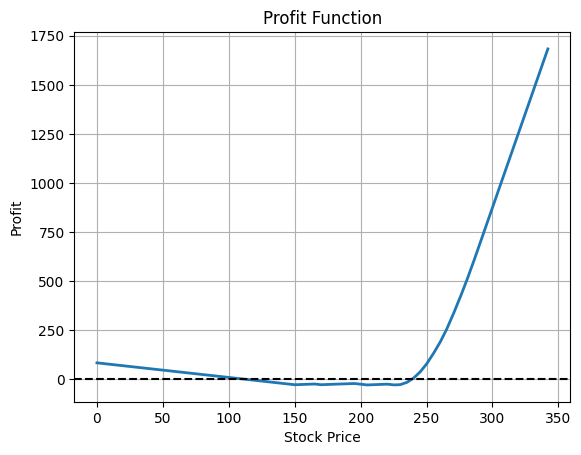

In [7]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.optimize import milp, LinearConstraint, Bounds
from prettytable import PrettyTable
import matplotlib.pyplot as plt

# ============ Helper για labels ============
def labeled_widget(label, widget, width="250px"):
    return widgets.HBox([widgets.HTML(f"<b>{label}</b>", layout=widgets.Layout(width=width)), widget])

# ============ Widgets με μόνο θετικές τιμές ============
V_box  = widgets.FloatText(value=10, min=0)
D_box  = widgets.FloatText(value=10)


KKmax_box = widgets.Textarea(
    value="100 0.5\n120 0.5",
    layout=widgets.Layout(width="300px", height="100px")
)

max_total_call_buy_box  = widgets.IntText(value=80, min=0)
max_total_put_buy_box   = widgets.IntText(value=80, min=0)
max_total_call_sell_box = widgets.IntText(value=80, min=0)
max_total_put_sell_box  = widgets.IntText(value=80, min=0)

max_call_buy_box  = widgets.IntText(value=2, min=0)
max_put_buy_box   = widgets.IntText(value=2, min=0)
max_call_sell_box = widgets.IntText(value=2, min=0)
max_put_sell_box  = widgets.IntText(value=2, min=0)

max_shares_buy_box  = widgets.IntText(value=100, min=0)
max_shares_sell_box = widgets.IntText(value=100, min=0)

max_bank_deposit_box = widgets.FloatText(value=0, min=0)
max_bank_loan_box    = widgets.FloatText(value=0, min=0)

run_button = widgets.Button(description="Run Optimization", button_style="success")
output = widgets.Output()

# ============ Layout ============

inputs = widgets.VBox([
    labeled_widget("Max Loss (D)", D_box),
    labeled_widget("Investment (V)", V_box),
    labeled_widget("Σημεία Πρόβλεψης και βάρη (K w, μία γραμμή ανά στόχο)", KKmax_box),
    labeled_widget("Total Calls Buy", max_total_call_buy_box),
    labeled_widget("Total Puts Buy", max_total_put_buy_box),
    labeled_widget("Total Calls Sell", max_total_call_sell_box),
    labeled_widget("Total Puts Sell", max_total_put_sell_box),
    labeled_widget("Max Call Buy / strike", max_call_buy_box),
    labeled_widget("Max Put Buy / strike", max_put_buy_box),
    labeled_widget("Max Call Sell / strike", max_call_sell_box),
    labeled_widget("Max Put Sell / strike", max_put_sell_box),
    labeled_widget("Max Shares Buy", max_shares_buy_box),
    labeled_widget("Max Shares Sell", max_shares_sell_box),
    labeled_widget("Max Bank Deposit", max_bank_deposit_box),
    labeled_widget("Max Bank Loan", max_bank_loan_box),
    run_button
])

# ============ Optimization Function ============

def run_all(b):
    with output:
        clear_output()

        # ----- Διαβάζουμε παραμέτρους -----
        D  = D_box.value
        V  = V_box.value

        KK_list = []
        for line in KKmax_box.value.strip().split("\n"):
            try:
                K, w = map(float, line.split())
                KK_list.append([K, w])
            except:
                print(f"Μη έγκυρη γραμμή: {line}")
        KKmax = np.array(KK_list)

        nC = len(call_strikes)
        nP = len(put_strikes)
        number_of_Kmaxes = KKmax.shape[0]
        union_strikes = np.union1d(call_strikes, put_strikes)
        max_element = float(union_strikes.max())

        # ----- Δείκτες μεταβλητών -----
        idx = {}
        idx['shares']          = 0
        idx['bank']            = 1
        idx['call_buy_start']  = 2
        idx['call_sell_start'] = 2 + nC
        idx['put_buy_start']   = 2 + 2*nC
        idx['put_sell_start']  = 2 + 2*nC + nP
        idx['Di_start']        = 2 + 2*nC + 2*nP
        tot_vars = idx['Di_start'] + number_of_Kmaxes

        # ----- Συνάρτηση payoff -----
        def PP(y):
            row = np.zeros(tot_vars)
            row[idx['shares']] = y
            row[idx['bank']]   = 1.0
            call_pay = np.maximum(y - call_strikes, 0.0)
            row[idx['call_buy_start']: idx['call_buy_start'] + nC] = call_pay
            row[idx['call_sell_start']: idx['call_sell_start'] + nC] = -call_pay
            put_pay = np.maximum(put_strikes - y, 0.0)
            row[idx['put_buy_start']: idx['put_buy_start'] + nP] = put_pay
            row[idx['put_sell_start']: idx['put_sell_start'] + nP] = -put_pay
            return row

        # ----- Constraints -----
        rows = []
        grid_points = np.concatenate(([0.0], union_strikes))
        for y in grid_points:
            rows.append(-PP(float(y)))
        grid_rows_end = len(rows) - 1

        Aderiv = np.zeros(tot_vars)
        Aderiv[idx['shares']] = -1.0
        Aderiv[idx['call_buy_start']: idx['call_buy_start'] + nC] = -1.0
        Aderiv[idx['call_sell_start']: idx['call_sell_start'] + nC] = +1.0
        rows.append(Aderiv)
        slope_row = len(rows) - 1

        for j in range(number_of_Kmaxes):
            K, _w = KKmax[j]
            r = -PP(float(K))
            r[idx['Di_start'] + j] = 1.0
            rows.append(r)
        kmax_rows_start = slope_row + 1
        kmax_rows_end   = len(rows) - 1

        Aequality = np.zeros(tot_vars)
        Aequality[idx['shares']] = stock_value
        Aequality[idx['bank']]   = 1.0
        Aequality[idx['call_buy_start']: idx['call_buy_start'] + nC] = call_ask
        Aequality[idx['call_sell_start']: idx['call_sell_start'] + nC] = -call_bid
        Aequality[idx['put_buy_start']: idx['put_buy_start'] + nP] = put_ask
        Aequality[idx['put_sell_start']: idx['put_sell_start'] + nP] = -put_bid
        rows.append(Aequality)
        cost_row = len(rows) - 1

        r = np.zeros(tot_vars); r[idx['call_buy_start']: idx['call_buy_start'] + nC] = 1.0
        rows.append(r); total_call_buy_row = len(rows) - 1
        r = np.zeros(tot_vars); r[idx['call_sell_start']: idx['call_sell_start'] + nC] = 1.0
        rows.append(r); total_call_sell_row = len(rows) - 1
        r = np.zeros(tot_vars); r[idx['put_buy_start']: idx['put_buy_start'] + nP] = 1.0
        rows.append(r); total_put_buy_row = len(rows) - 1
        r = np.zeros(tot_vars); r[idx['put_sell_start']: idx['put_sell_start'] + nP] = 1.0
        rows.append(r); total_put_sell_row = len(rows) - 1

        AA = np.vstack(rows)

        b  = np.zeros(AA.shape[0])
        bl = np.full_like(b, -np.inf, dtype=float)
        b[:grid_rows_end+1] = D - V
        b[slope_row] = 0.0
        b[kmax_rows_start : kmax_rows_end+1] = -V
        b[cost_row]  = V
        bl[cost_row] = V
        b[total_call_buy_row]  = max_total_call_buy_box.value
        b[total_call_sell_row] = max_total_call_sell_box.value
        b[total_put_buy_row]   = max_total_put_buy_box.value
        b[total_put_sell_row]  = max_total_put_sell_box.value
        constraints = LinearConstraint(AA, bl, b)

        ub = np.zeros(tot_vars); lb = np.zeros(tot_vars)
        ub[idx['shares']] = max_shares_buy_box.value
        lb[idx['shares']] = -max_shares_sell_box.value
        ub[idx['bank']] =  max_bank_deposit_box.value
        lb[idx['bank']] = -max_bank_loan_box.value
        ub[idx['call_buy_start']: idx['call_buy_start'] + nC] = max_call_buy_box.value
        ub[idx['call_sell_start']: idx['call_sell_start'] + nC] = max_call_sell_box.value
        ub[idx['put_buy_start']: idx['put_buy_start'] + nP] = max_put_buy_box.value
        ub[idx['put_sell_start']: idx['put_sell_start'] + nP] = max_put_sell_box.value
        ub[idx['Di_start']: idx['Di_start'] + number_of_Kmaxes] = np.inf
        bounds = Bounds(lb, ub)

        integrality = np.ones(tot_vars, dtype=int)
        integrality[idx['shares']] = 0
        integrality[idx['bank']]   = 0
        integrality[idx['Di_start']: idx['Di_start'] + number_of_Kmaxes] = 0

        f = np.zeros(tot_vars)
        f[idx['Di_start']: idx['Di_start'] + number_of_Kmaxes] = -KKmax[:, 1]

        # ----- Επίλυση -----
        res = milp(c=f, constraints=constraints, integrality=integrality, bounds=bounds)
        if res.x is None:
            print("MILP infeasible. Δοκίμασε χαλαρότερα όρια ή διαφορετικό V/D.")
            return
        x = res.x





        # ===== ΑΠΑΙΤΗΣΕΙΣ ΠΟΡΩΝ ΓΙΑ ΑΣΚΗΣΕΙΣ/ΑΝΑΘΕΣΕΙΣ =====
        M = 100  # contract multiplier (π.χ. 100 μετοχές/συμβόλαιο)

        # Ποσότητες (από τη λύση x)
        qty_shares = x[idx['shares']]
        qty_bank   = x[idx['bank']]

        q_call_buy  = x[idx['call_buy_start']  : idx['call_buy_start']  + nC]
        q_call_sell = x[idx['call_sell_start'] : idx['call_sell_start'] + nC]
        q_put_buy   = x[idx['put_buy_start']   : idx['put_buy_start']   + nP]
        q_put_sell  = x[idx['put_sell_start']  : idx['put_sell_start']  + nP]

        # --- Ακαθάριστες απαιτήσεις ---
        # Μετρητά που χρειάζονται για να μπορώ να ασκήσω/ανταποκριθώ:
        cash_need_long_calls = M * float(np.dot(q_call_buy,  call_strikes))   # Long Calls: K ανά συμβόλαιο
        cash_need_short_puts = M * float(np.dot(q_put_sell, put_strikes))     # Short Puts: K ανά συμβόλαιο
        cash_required_gross  = max(0.0, cash_need_long_calls + cash_need_short_puts)

        # Μετοχές που χρειάζονται για παράδοση/κάλυψη:
        shares_need_long_puts  = M * float(np.sum(q_put_buy))                 # Long Puts: 1 share per contract
        shares_need_short_calls = M * float(np.sum(q_call_sell))              # Short Calls: 1 share per contract
        shares_required_gross   = max(0.0, shares_need_long_puts + shares_need_short_calls)

        # --- Διαθέσιμα από το ίδιο χαρτοφυλάκιο (θετικές θέσεις μόνο) ---
        available_cash   = max(0.0, qty_bank)     # κατάθεση (bank>0)
        available_shares = max(0.0, qty_shares)   # long μετοχές

        # --- Καθαρές απαιτήσεις (τι επιπλέον πρέπει να έχεις) ---
        cash_required_net   = max(0.0, cash_required_gross   - available_cash)
        shares_required_net = max(0.0, shares_required_gross - available_shares)

        # Εκτύπωση συνοπτικού πίνακα
        t_req = PrettyTable(['Resource', 'Gross Required', 'Available (from x)', 'Net Required'])
        t_req.add_row(['Cash (EUR)',   f"{cash_required_gross:,.2f}",   f"{available_cash:,.2f}",   f"{cash_required_net:,.2f}"])
        t_req.add_row(['Shares (#)',   f"{shares_required_gross:,.0f}", f"{available_shares:,.0f}", f"{shares_required_net:,.0f}"])

        print("\n=== Requirements to Operate (Exercise/Assignment Ready) ===")
        print(t_req)

        # ===== ΠΙΝΑΚΑΣ ΜΕΤΟΧΩΝ =====
        t_shares = PrettyTable(['Asset', 'Action', 'Quantity', 'Price', 'Total'])
        qty_shares = x[idx['shares']]
        if abs(qty_shares) > 1e-6:
            action = "Buy" if qty_shares > 0 else "Sell"
            t_shares.add_row([Firm, action, abs(qty_shares),
                              f"{stock_value:.2f}", f"{qty_shares*stock_value:.2f}"])
        else:
            t_shares.add_row([Firm, "-", 0, "-", "-"])
        print("\n=== Shares ===")
        print(t_shares)

        # ===== ΠΙΝΑΚΑΣ OPTIONS =====
        t_opts = PrettyTable(['Type', 'Strike', 'Action', 'Quantity', 'Unit Price', 'Total'])
        for j in range(nC):
            q = x[idx['call_buy_start'] + j]
            if q > 1e-3:
                t_opts.add_row(['Call', float(call_strikes[j]), "Buy", int(round(q)),
                                f"{call_ask[j]:.2f}", f"{q*call_ask[j]:.2f}"])
        for j in range(nC):
            q = x[idx['call_sell_start'] + j]
            if q > 1e-3:
                t_opts.add_row(['Call', float(call_strikes[j]), "Sell", int(round(q)),
                                f"{call_bid[j]:.2f}", f"{q*call_bid[j]:.2f}"])
        for j in range(nP):
            q = x[idx['put_buy_start'] + j]
            if q > 1e-3:
                t_opts.add_row(['Put', float(put_strikes[j]), "Buy", int(round(q)),
                                f"{put_ask[j]:.2f}", f"{q*put_ask[j]:.2f}"])
        for j in range(nP):
            q = x[idx['put_sell_start'] + j]
            if q > 1e-3:
                t_opts.add_row(['Put', float(put_strikes[j]), "Sell", int(round(q)),
                                f"{put_bid[j]:.2f}", f"{q*put_bid[j]:.2f}"])
        print("\n=== Options ===")
        print(t_opts)

        # ===== ΠΙΝΑΚΑΣ BANK =====
        t_bank = PrettyTable(['Account', 'Action', 'Amount'])
        bank_amt = x[idx['bank']]
        if bank_amt > 1e-6:
            t_bank.add_row(['Bank', 'Deposit', f"{abs(bank_amt):.2f}"])
        elif bank_amt < -1e-6:
            t_bank.add_row(['Bank', 'Borrow', f"{abs(bank_amt):.2f}"])
        else:
            t_bank.add_row(['Bank', '-', "0.00"])
        print("\n=== Bank Account ===")
        print(t_bank)

        # ===== PROFIT PLOT =====
        def profit_function(y):
            return float(PP(y) @ x - V)

        ymax = max_element * 1.2
        y_values = np.linspace(0, ymax, 500)
        profit_values = [profit_function(y) for y in y_values]

        plt.figure()
        plt.plot(y_values, profit_values, linewidth=2)
        plt.axhline(0, color="black", linestyle="--")
        plt.xlabel("Stock Price")
        plt.ylabel("Profit")
        plt.title("Profit Function")
        plt.grid(True)
        plt.show()

# Σύνδεση κουμπιού
run_button.on_click(run_all)

# Εμφάνιση στο Colab
display(inputs, output)